In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import pandas

import glob
import os
import json

import sncosmo
import piscola as pisco
from astropy.table import Table


#sns.set(font_scale=1.5, context='paper', style='white')
%config InlineBackend.figure_format = 'retina'
plt.rcParams["font.family"] = "Gentium"
plt.rcParams['mathtext.fontset'] = "cm"
new_palette = [plt.get_cmap('Dark2')(i) for i in np.arange(8)] + [plt.get_cmap('Set1')(i) for i in np.arange(8)]

# plot:
## sn2004eo, SDSS6936, 03D1au and psc000174
## sn2008ar, SDSS6057, 04D3fq and psc520022

In [24]:
name = 'psc000174'
sn = pisco.load_sn(name, '../analysis/obj_pantheon')   

# sn = pisco.call_sn(name, '../analysis/data_pantheon')   
# sn.normalize_data()
# sn.fit_lcs()
# sn.plot_fits()
# sn.save_sn(name, '../analysis/obj_pantheon')

In [4]:
def piscola2sncosmo(sn, zpsys='ab'): 
    '''Converts a PISCOLA object to data that can be read by sncosmo'''
    
    sn_df = pd.DataFrame({col:[] for col in sn.data[sn.bands[0]].keys()}) 

    for band in sn.bands:
        band_df = pd.DataFrame(sn.data[band]) 
        band_df['band'] = band
        band_df['zpsys'] = zpsys
        sn_df = pd.concat([sn_df, band_df], sort=False)

    sn_table = Table.from_pandas(sn_df)  
    return sn_table

def fit_salt2(name, use_salt2_params=True):
    
    # load salt2 parameters
    sample_file = '../analysis/test_files//Pantheon/hlsp_ps1cosmo_panstarrs_gpc1_all_model_v1_ancillary-g10.fitres'
    sample_df = pd.read_csv(sample_file, delim_whitespace=True, comment='#')
    
    assert name in sample_df.CID.values, f'SN {name} is not in found in the pantheon file: {os.path.basename(sample_file)}'
    
    sn_vals = sample_df[sample_df.CID==name]
    
    # load SN photometry
    sn_file = [file for file in glob.glob('../analysis/data_pantheon/*') if name in file][0]
    df = pd.read_csv(sn_file, delim_whitespace=True, skiprows=2)
    
    pisco_name = os.path.basename(sn_file).split('.')[0]
    sn = pisco.call_sn(pisco_name, directory='../analysis/data_pantheon') 
    
    # select calibration file
    ppath = pisco.__path__[0]
    if sn.data[sn.bands[0]]['mag_sys'].lower()=='bd17':
        zps_file = os.path.join(ppath, 'standards/bd17_sys_zps.dat')
        zpsys = 'bd17'
    elif sn.data[sn.bands[0]]['mag_sys'].lower()=='ab':
        zps_file = os.path.join(ppath, 'standards/ab_sys_zps.dat')
        zpsys = 'ab'
    zp_dict = {} 

    # add filters, zps and magnitude system to sncosmo registry
    for band in sn.bands:
        bandpass = sncosmo.Bandpass(sn.filters[band]['wave'], sn.filters[band]['transmission'], name=band) 
        sncosmo.register(bandpass, band, force=True)

        with open(zps_file, 'r') as zpsys_file:
            zp = [line.split()[1] for line in zpsys_file if band in line.split()][0]
            zp = eval(zp)
            zp_dict.update({band:(zpsys, zp)})

    magsys = sncosmo.CompositeMagSystem(bands=zp_dict, name='pantheon')    
    sncosmo.registry.register(magsys, force=True)
    
    # add the SN parameters to the sncosmo model (salt2)
    dust = sncosmo.F99Dust()
    dust.set(ebv=sn_vals.MWEBV.values[0]) 

    model = sncosmo.Model(source='salt2', effects=[dust], effect_names=['mwebv'], effect_frames=['obs'])
    data = piscola2sncosmo(sn, zpsys)
    
    if use_salt2_params:
        # NOTE - SNANA SALT2 implementation has a 0.27 mag offset from sncosmo.
        # this doesn't matter at all for most things like cosmology analyses,
        # but certainly matters for making plots
        model.set(z=sn_vals.zCMB.values, t0=sn_vals.PKMJD.values,
                  x1=sn_vals.x1.values, c=sn_vals.c.values, x0=sn_vals.x0.values*10**(-0.4*(0.27)))  
        result, fitted_model = sncosmo.fit_lc(data, model, ['t0', 'x0', 'x1', 'c'],)
    else:
        model.set(z=sn_vals.zCMB.values)
        result, fitted_model = sncosmo.fit_lc(data, model, ['z', 't0', 'x0', 'x1', 'c'], bounds={'z':(0.0, 0.7)})
    
    return fitted_model, zpsys

In [110]:
def create_subplot_salt2(ax, sn, fitted_model, zpsys, y_norm=1, title=None):
    '''Plot a SN of a subplot.
    '''
    
    for i, band in enumerate(sn.bands):
        
        band_label = band
        if band=='csp_o':
            band_label = 'csp_V'
        # Data
        data_time, data_flux, data_flux_err = np.copy(sn.data[band]['time']), np.copy(sn.data[band]['flux']), np.copy(sn.data[band]['flux_err'])

        # normalise values
        data_flux, data_flux_err = data_flux/y_norm, data_flux_err/y_norm
        ax.errorbar(data_time, data_flux, data_flux_err, fmt='.', capsize=3, capthick=2, ms=8,
                        elinewidth=3, color=new_palette[i], label=band_label)
        try:
            time = np.arange(sn.tmax-20, sn.tmax+40.5, 0.5)
            flux = fitted_model.bandflux(band, time, zp=sn.data[band]['zp'], zpsys=zpsys)/y_norm
            ax.plot(time, flux,'-', color=new_palette[i], lw=2)
        except:
            pass
            
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlim(sn.tmax-20, sn.tmax+40)
    
    if title is None:
        title = sn.name
    ax.text(sn.tmax-18.5, 0.95, title, fontsize=20)
    ax.text(sn.tmax-18.5, 0.95, title, fontsize=20)
        
def create_subplot_salt2_residuals(ax, sn, fitted_model, zpsys, y_norm=1, title=None):
    '''Plot a SN of a subplot.
    '''
    
    for i, band in enumerate(sn.bands):
            
        # Data
        data_time, data_flux, data_flux_err = np.copy(sn.data[band]['time']), np.copy(sn.data[band]['flux']), np.copy(sn.data[band]['flux_err'])
        
        # normalise values
        data_flux, data_flux_err = data_flux/y_norm, data_flux_err/y_norm
        try:
            time = np.arange(sn.tmax-20, sn.tmax+40.5, 0.5)
            flux = fitted_model.bandflux(band, time, zp=sn.data[band]['zp'], zpsys=zpsys)/y_norm
            ax.axhline(0, ls='--', color='k')

            mask = [np.argmin(np.abs(t-time)) for t in data_time]
            ax.errorbar(data_time, data_flux-flux[mask], data_flux_err, fmt='o', capsize=3, capthick=2, ms=6,
                        elinewidth=3, color=new_palette[i], label=band)

        except:
            pass

    ax.set_ylim(-0.15, 0.15)
    ax.set_xlim(sn.tmax-20, sn.tmax+40)
    
    if title is None:
        title = sn.name
    #ax.text(sn.tmax-17, 0.10, title, fontsize=20)
    ax.text(sn.tmax+27, 0.10, f'z = {sn.z:.3f}', fontsize=20)

In [107]:
def create_subplot(ax, sn, y_norm=1, title=None):
    '''Plot a SN of a subplot.
    '''
    
    for i, band in enumerate(sn.bands):

        # GP fits
        time, flux, flux_err = np.copy(sn.lc_fits[band]['time']), np.copy(sn.lc_fits[band]['flux']), np.copy(sn.lc_fits[band]['flux_err'])
        mag, mag_err = np.copy(sn.lc_fits[band]['mag']), np.copy(sn.lc_fits[band]['mag_err'])
        # Data
        data_time, data_flux, data_flux_err = np.copy(sn.data[band]['time']), np.copy(sn.data[band]['flux']), np.copy(sn.data[band]['flux_err'])
        data_mag, data_mag_err = np.copy(sn.data[band]['mag']), np.copy(sn.data[band]['mag_err'])

        # scale values
        flux, flux_err = flux/y_norm, flux_err/y_norm
        data_flux, data_flux_err = data_flux/y_norm, data_flux_err/y_norm

        if band=='csp_o':
            band = 'csp_V'
        # plots
        ax.errorbar(data_time, data_flux, data_flux_err, fmt='.', capsize=3, capthick=2, ms=8,
                        elinewidth=3, color=new_palette[i], label=band)
        ax.plot(time, flux,'-', color=new_palette[i], lw=2)

            
        ax.set_ylim(-0.05, 1.05)
        ax.set_xlim(sn.tmax-20, sn.tmax+40)
        
        if title is None:
            title = sn.name
        ax.text(sn.tmax-18.5, 0.95, title, fontsize=20)
    
def create_subplot_residuals(ax, sn, y_norm=1, title=None):
    '''Plot a SN of a subplot.
    '''
    
    for i, band in enumerate(sn.bands):

        # GP fits
        time, flux, flux_err = np.copy(sn.lc_fits[band]['time']), np.copy(sn.lc_fits[band]['flux']), np.copy(sn.lc_fits[band]['flux_err'])
        mag, mag_err = np.copy(sn.lc_fits[band]['mag']), np.copy(sn.lc_fits[band]['mag_err'])
        # Data
        data_time, data_flux, data_flux_err = np.copy(sn.data[band]['time']), np.copy(sn.data[band]['flux']), np.copy(sn.data[band]['flux_err'])
        data_mag, data_mag_err = np.copy(sn.data[band]['mag']), np.copy(sn.data[band]['mag_err'])
        
        # scale values
        flux, flux_err = flux/y_norm, flux_err/y_norm
        data_flux, data_flux_err = data_flux/y_norm, data_flux_err/y_norm
        
        # plot
        mask = [np.argmin(np.abs(t-time)) for t in data_time]
        ax.errorbar(data_time, data_flux-flux[mask], data_flux_err, fmt='o', capsize=3, capthick=2, ms=6,
                        elinewidth=3, color=new_palette[i], label=band)
        ax.axhline(0, ls='--', color='k')
            
    ax.set_ylim(-0.15, 0.15)
    ax.set_xlim(sn.tmax-20, sn.tmax+40)
    
    if title is None:
        title = sn.name
    #ax.text(sn.tmax-17, 0.10, title, fontsize=20)
    ax.text(sn.tmax+27, 0.10, f'z = {sn.z:.3f}', fontsize=20)

/home/tomas/anaconda3/envs/pisco/lib/python3.6/site-packages/sncosmo/fitting.py:156: RuntimeWarning: Dropping following bands from data: sdss_z(out of model wavelength range)
  "(out of model wavelength range)", RuntimeWarning)


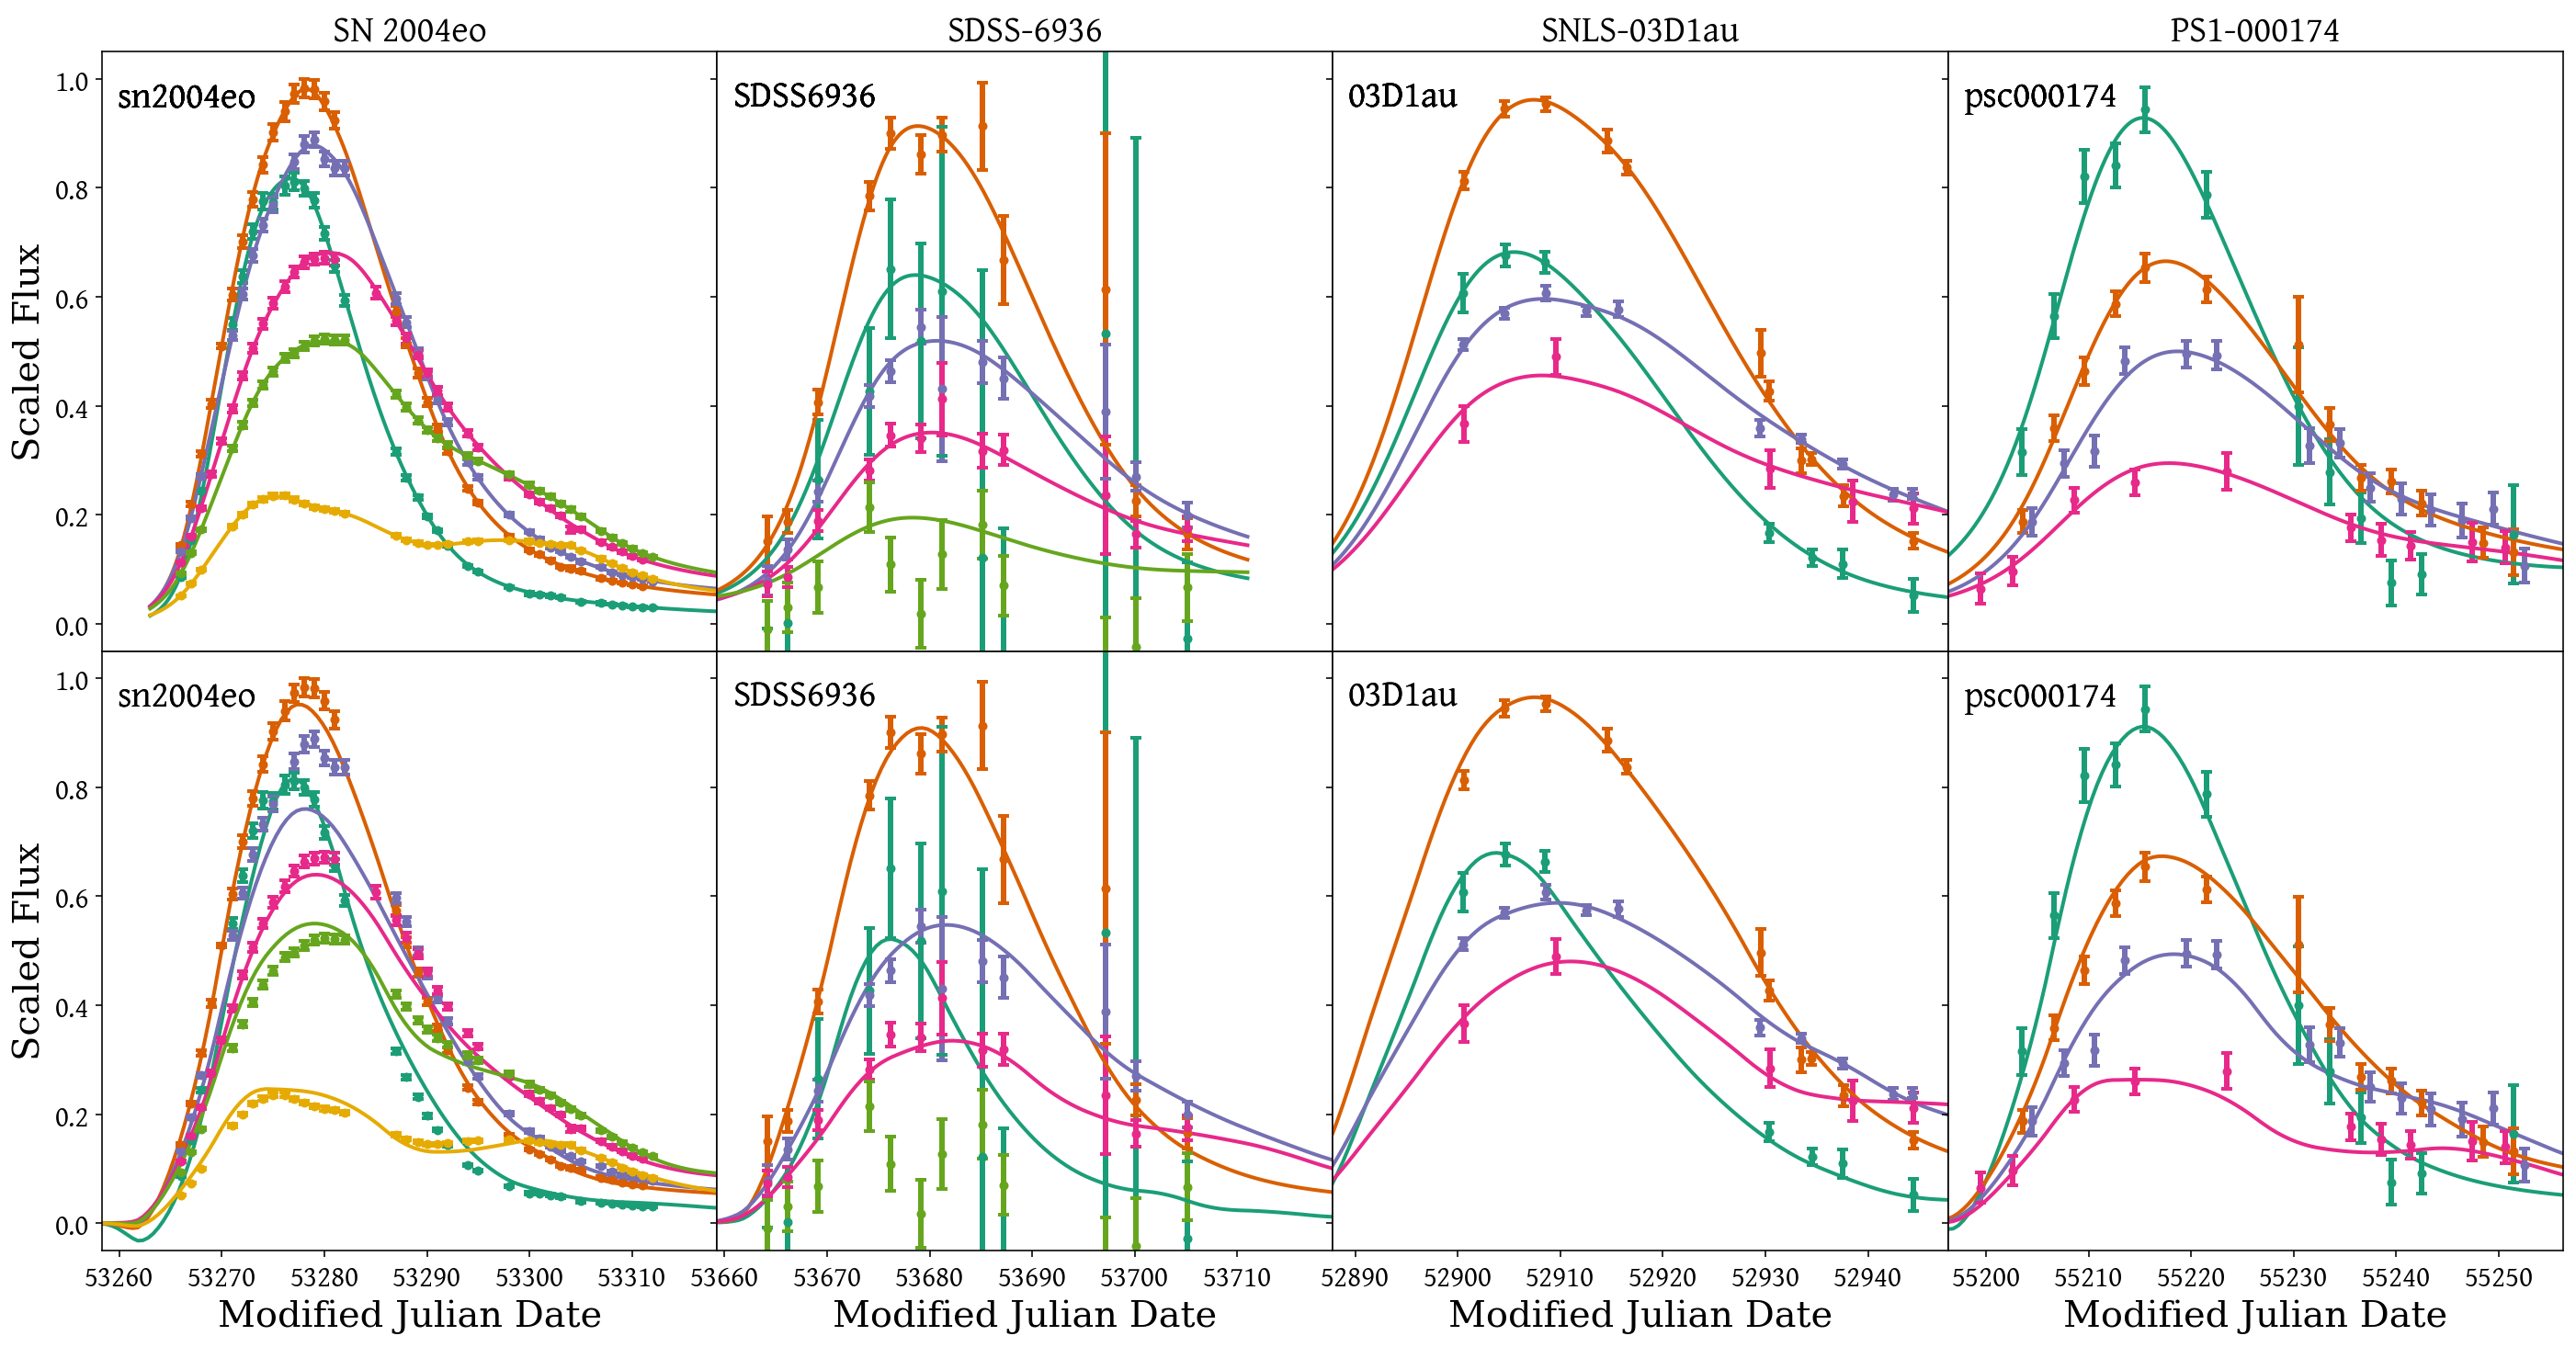

In [111]:
sn_list = ['sn2004eo', 'SDSS6936', '03D1au', 'psc000174']
sn_list_salt2 = ['2004eo', '6936', '03D1au', '000174']
titles = ['SN 2004eo', 'SDSS-6936', 'SNLS-03D1au', 'PS1-000174']
y_norms = [4e-15, 3.3e-17, 2.8e-18, 1.2e-17]

sn_list_2 = ['sn2008ar', 'SDSS6057', '04D3fq', 'psc520022']
sn_list_salt2_2 = ['2008ar', '6057', '04D3fq', '520022']
titles_2 = ['SN 2008ar', 'SDSS-6057', 'SNLS-04D3fq', 'PS1-520022']
y_norms_2 = [1.9e-15, 1.5e-16, 0.95e-18, 4e-17]

# plots
fig, ax = plt.subplots(2, len(sn_list), figsize=(24, 12), sharey=True)

for i, (name, name_salt2, y_norm, title) in enumerate(zip(sn_list, sn_list_salt2, y_norms, titles)):
    
    # piscola
    sn = pisco.load_sn(name, '../analysis/obj_pantheon')  
    create_subplot(ax[0, i], sn, y_norm)
    
    # salt2
    fitted_model, zpsys = fit_salt2(name_salt2)
    create_subplot_salt2(ax[1, i], sn, fitted_model, zpsys, y_norm)
    
    ax[0, i].set_title(title, fontsize=20)
    ax[0, i].set_xticks([])
    ax[1, i].set_xlabel(f'Modified Julian Date', fontsize=20, family='serif')
    ax[1, i].tick_params(labelsize=16)
    

ax[0, 0].set_ylabel(f'Scaled Flux', fontsize=20, family='serif')
ax[1, 0].set_ylabel(f'Scaled Flux', fontsize=20, family='serif')
ax[0, 0].tick_params(labelsize=16)

plt.subplots_adjust(wspace=0, hspace=0)
if plot_type=='mag':
    plt.gca().invert_yaxis()

#plt.savefig('plots/fits_comparison.pdf', bbox_inches='tight')
plt.show()

/home/tomas/anaconda3/envs/pisco/lib/python3.6/site-packages/sncosmo/fitting.py:156: RuntimeWarning: Dropping following bands from data: sdss_z(out of model wavelength range)
  "(out of model wavelength range)", RuntimeWarning)
/home/tomas/anaconda3/envs/pisco/lib/python3.6/site-packages/sncosmo/fitting.py:156: RuntimeWarning: Dropping following bands from data: sdss_z(out of model wavelength range)
  "(out of model wavelength range)", RuntimeWarning)


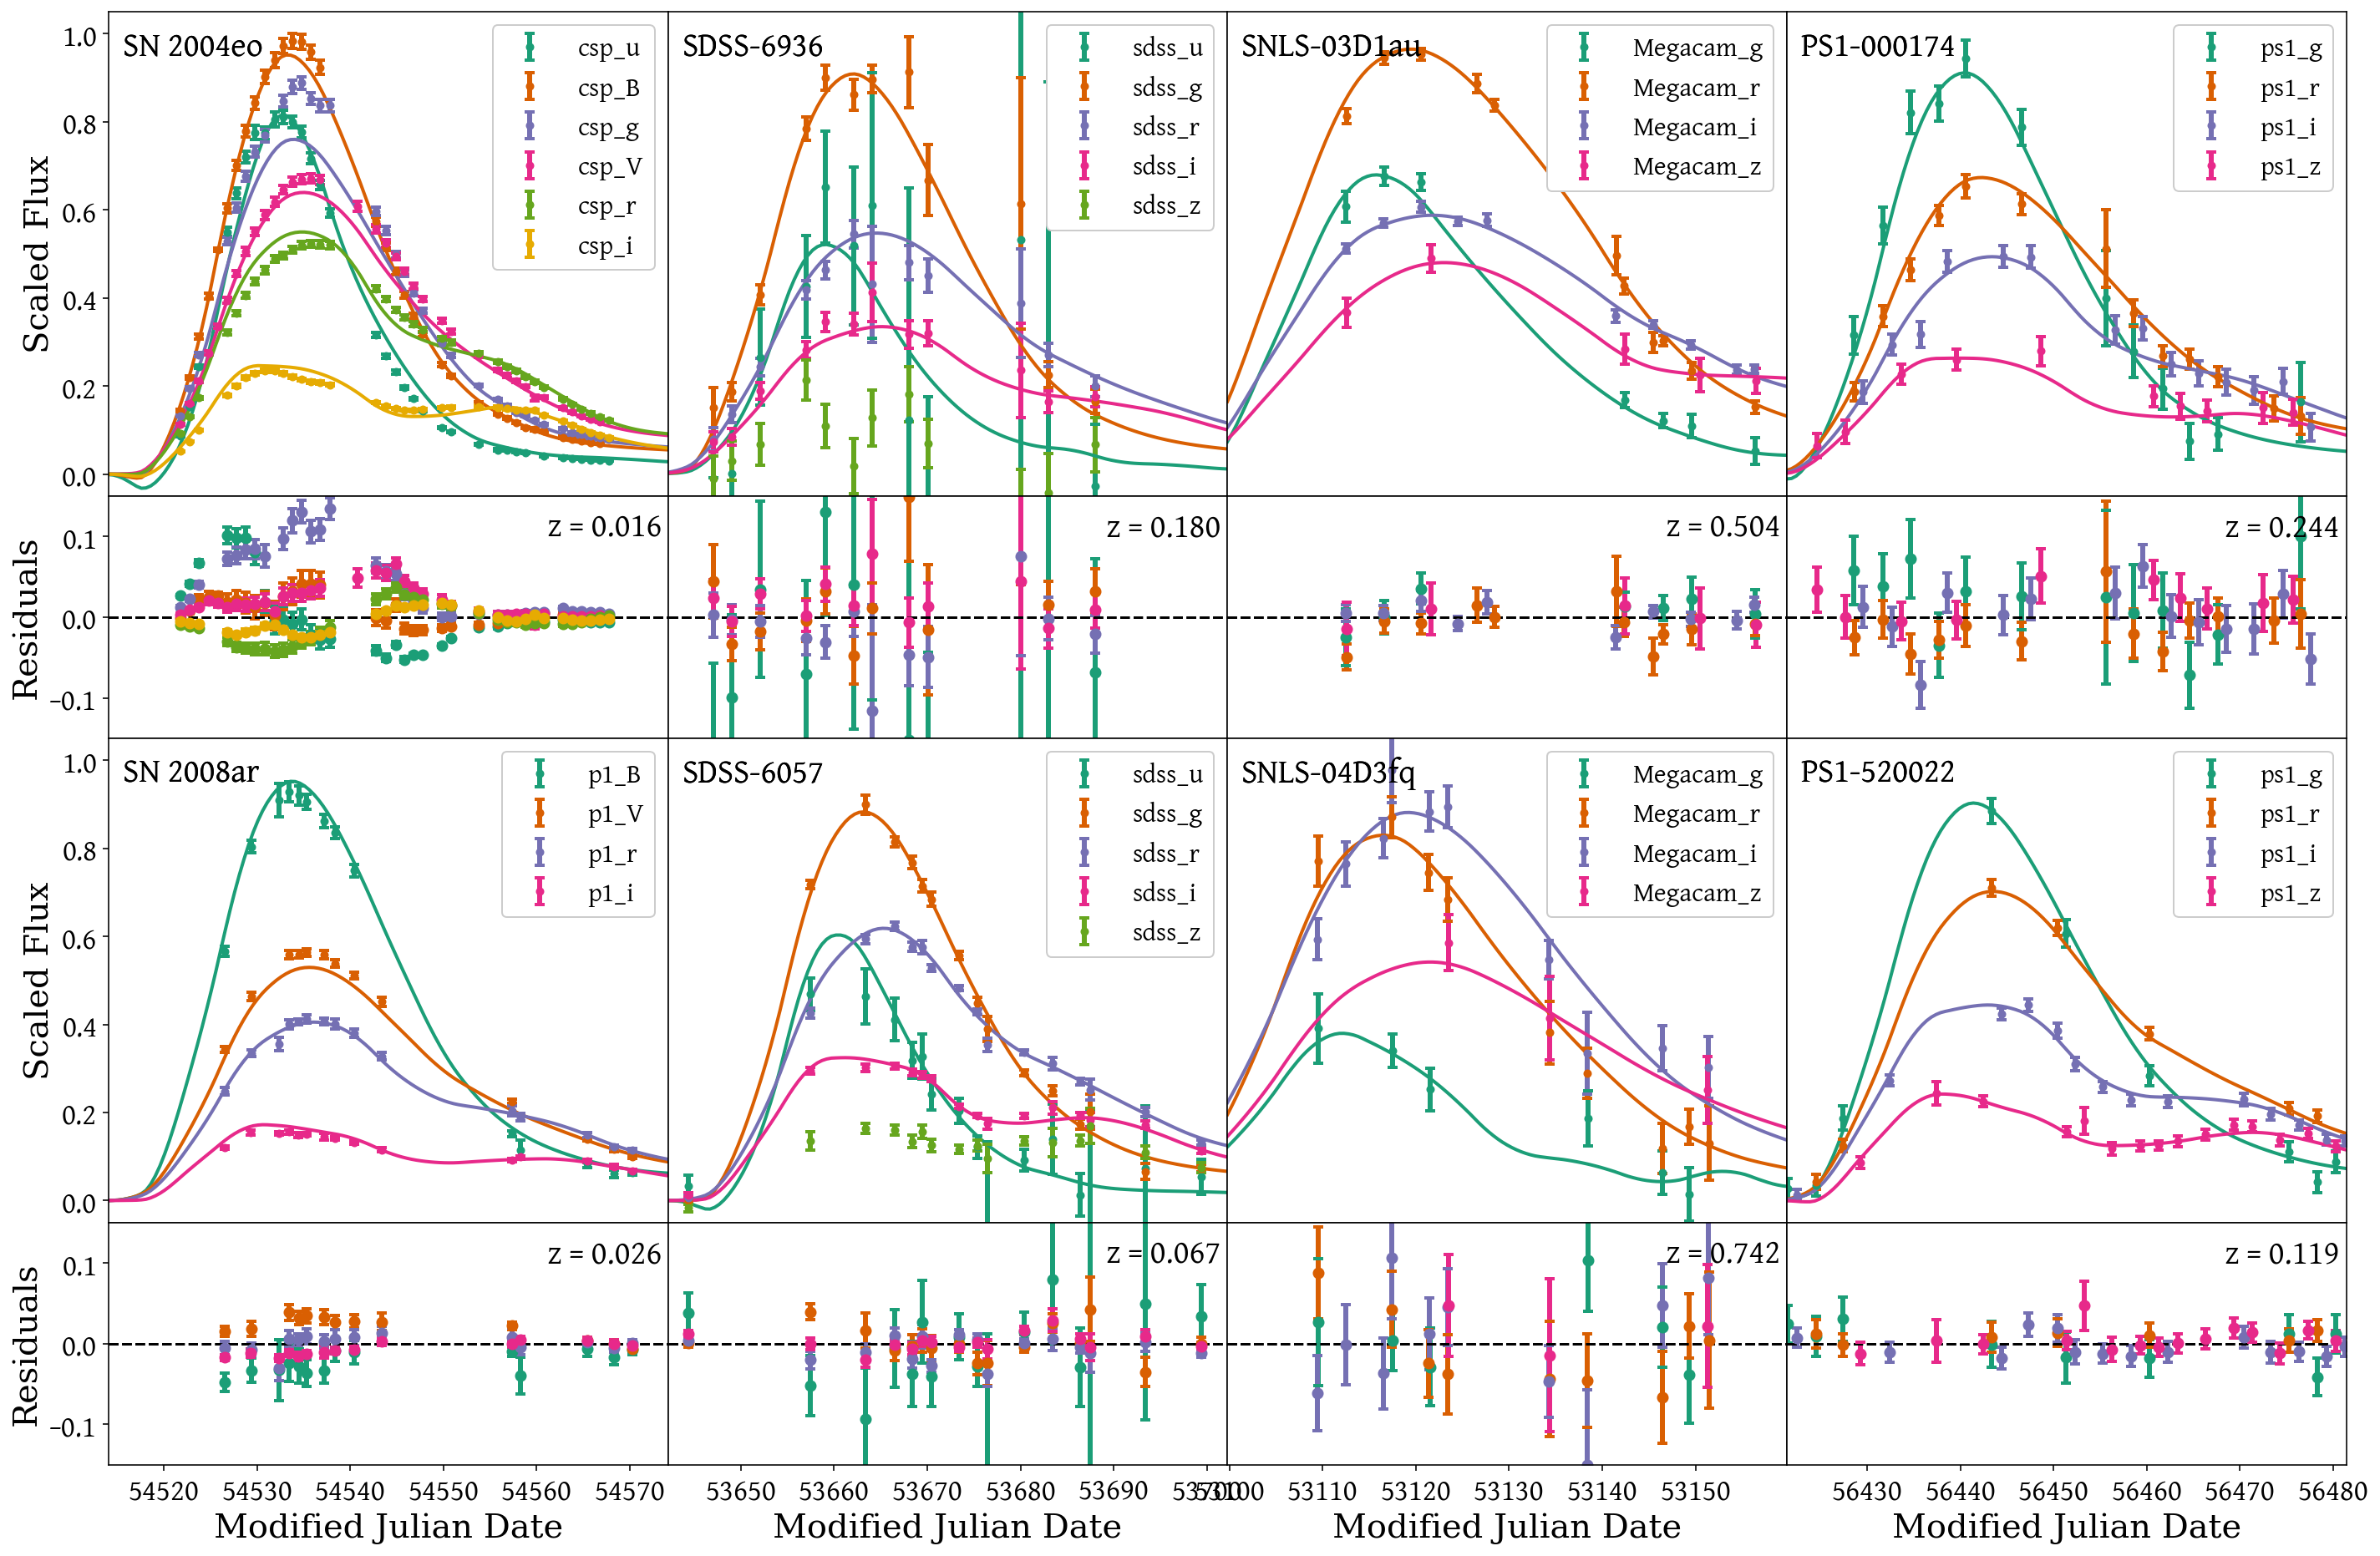

In [112]:
# plots
fig, ax = plt.subplots(4, len(sn_list), figsize=(24, 16), gridspec_kw={'height_ratios': [2, 1, 2, 1]})

for i, (name, name_salt2, y_norm, title, name_2, name_salt2_2, y_norm_2, title_2) in enumerate(zip(sn_list, sn_list_salt2, y_norms, titles, 
                                                                                              sn_list_2, sn_list_salt2_2, y_norms_2, titles_2)):
    
    # pisco data
    sn = pisco.load_sn(name, '../analysis/obj_pantheon')  
    # top
    fitted_model, zpsys = fit_salt2(name_salt2)
    create_subplot_salt2(ax[0, i], sn, fitted_model, zpsys, y_norm, title)
    create_subplot_salt2_residuals(ax[1, i], sn, fitted_model, zpsys, y_norm, title)
    
    # pisco data
    sn = pisco.load_sn(name_2, '../analysis/obj_pantheon')  
    # bottom
    fitted_model, zpsys = fit_salt2(name_salt2_2)
    create_subplot_salt2(ax[2, i], sn, fitted_model, zpsys, y_norm_2, title_2)
    create_subplot_salt2_residuals(ax[3, i], sn, fitted_model, zpsys, y_norm_2, title_2)
    
    #ax[0, i].set_title(title, fontsize=20)
    ax[0, i].set_xticks([])
    ax[1, i].set_xticks([])
    ax[2, i].set_xticks([])
    if i!=0:
        ax[0, i].set_yticks([])
        ax[1, i].set_yticks([])
        ax[2, i].set_yticks([])
        ax[3, i].set_yticks([])
    ax[3, i].set_xlabel(f'Modified Julian Date', fontsize=20, family='serif')
    ax[3, i].tick_params(labelsize=18)    

    ax[0, i].legend(fontsize=16, ncol=1, framealpha=1)
    ax[2, i].legend(fontsize=16, ncol=1, framealpha=1)
    
ax[0, 0].set_ylabel(f'Scaled Flux', fontsize=20, family='serif')
ax[1, 0].set_ylabel(f'Residuals', fontsize=20, family='serif')
ax[2, 0].set_ylabel(f'Scaled Flux', fontsize=20, family='serif')
ax[3, 0].set_ylabel(f'Residuals', fontsize=20, family='serif')
ax[0, 0].tick_params(labelsize=18)
ax[1, 0].tick_params(labelsize=18)
ax[2, 0].tick_params(labelsize=18)

plt.subplots_adjust(wspace=0, hspace=0)
if plot_type=='mag':
    plt.gca().invert_yaxis()

plt.savefig('plots/fits_comparison_salt2.pdf', bbox_inches='tight')
plt.show()

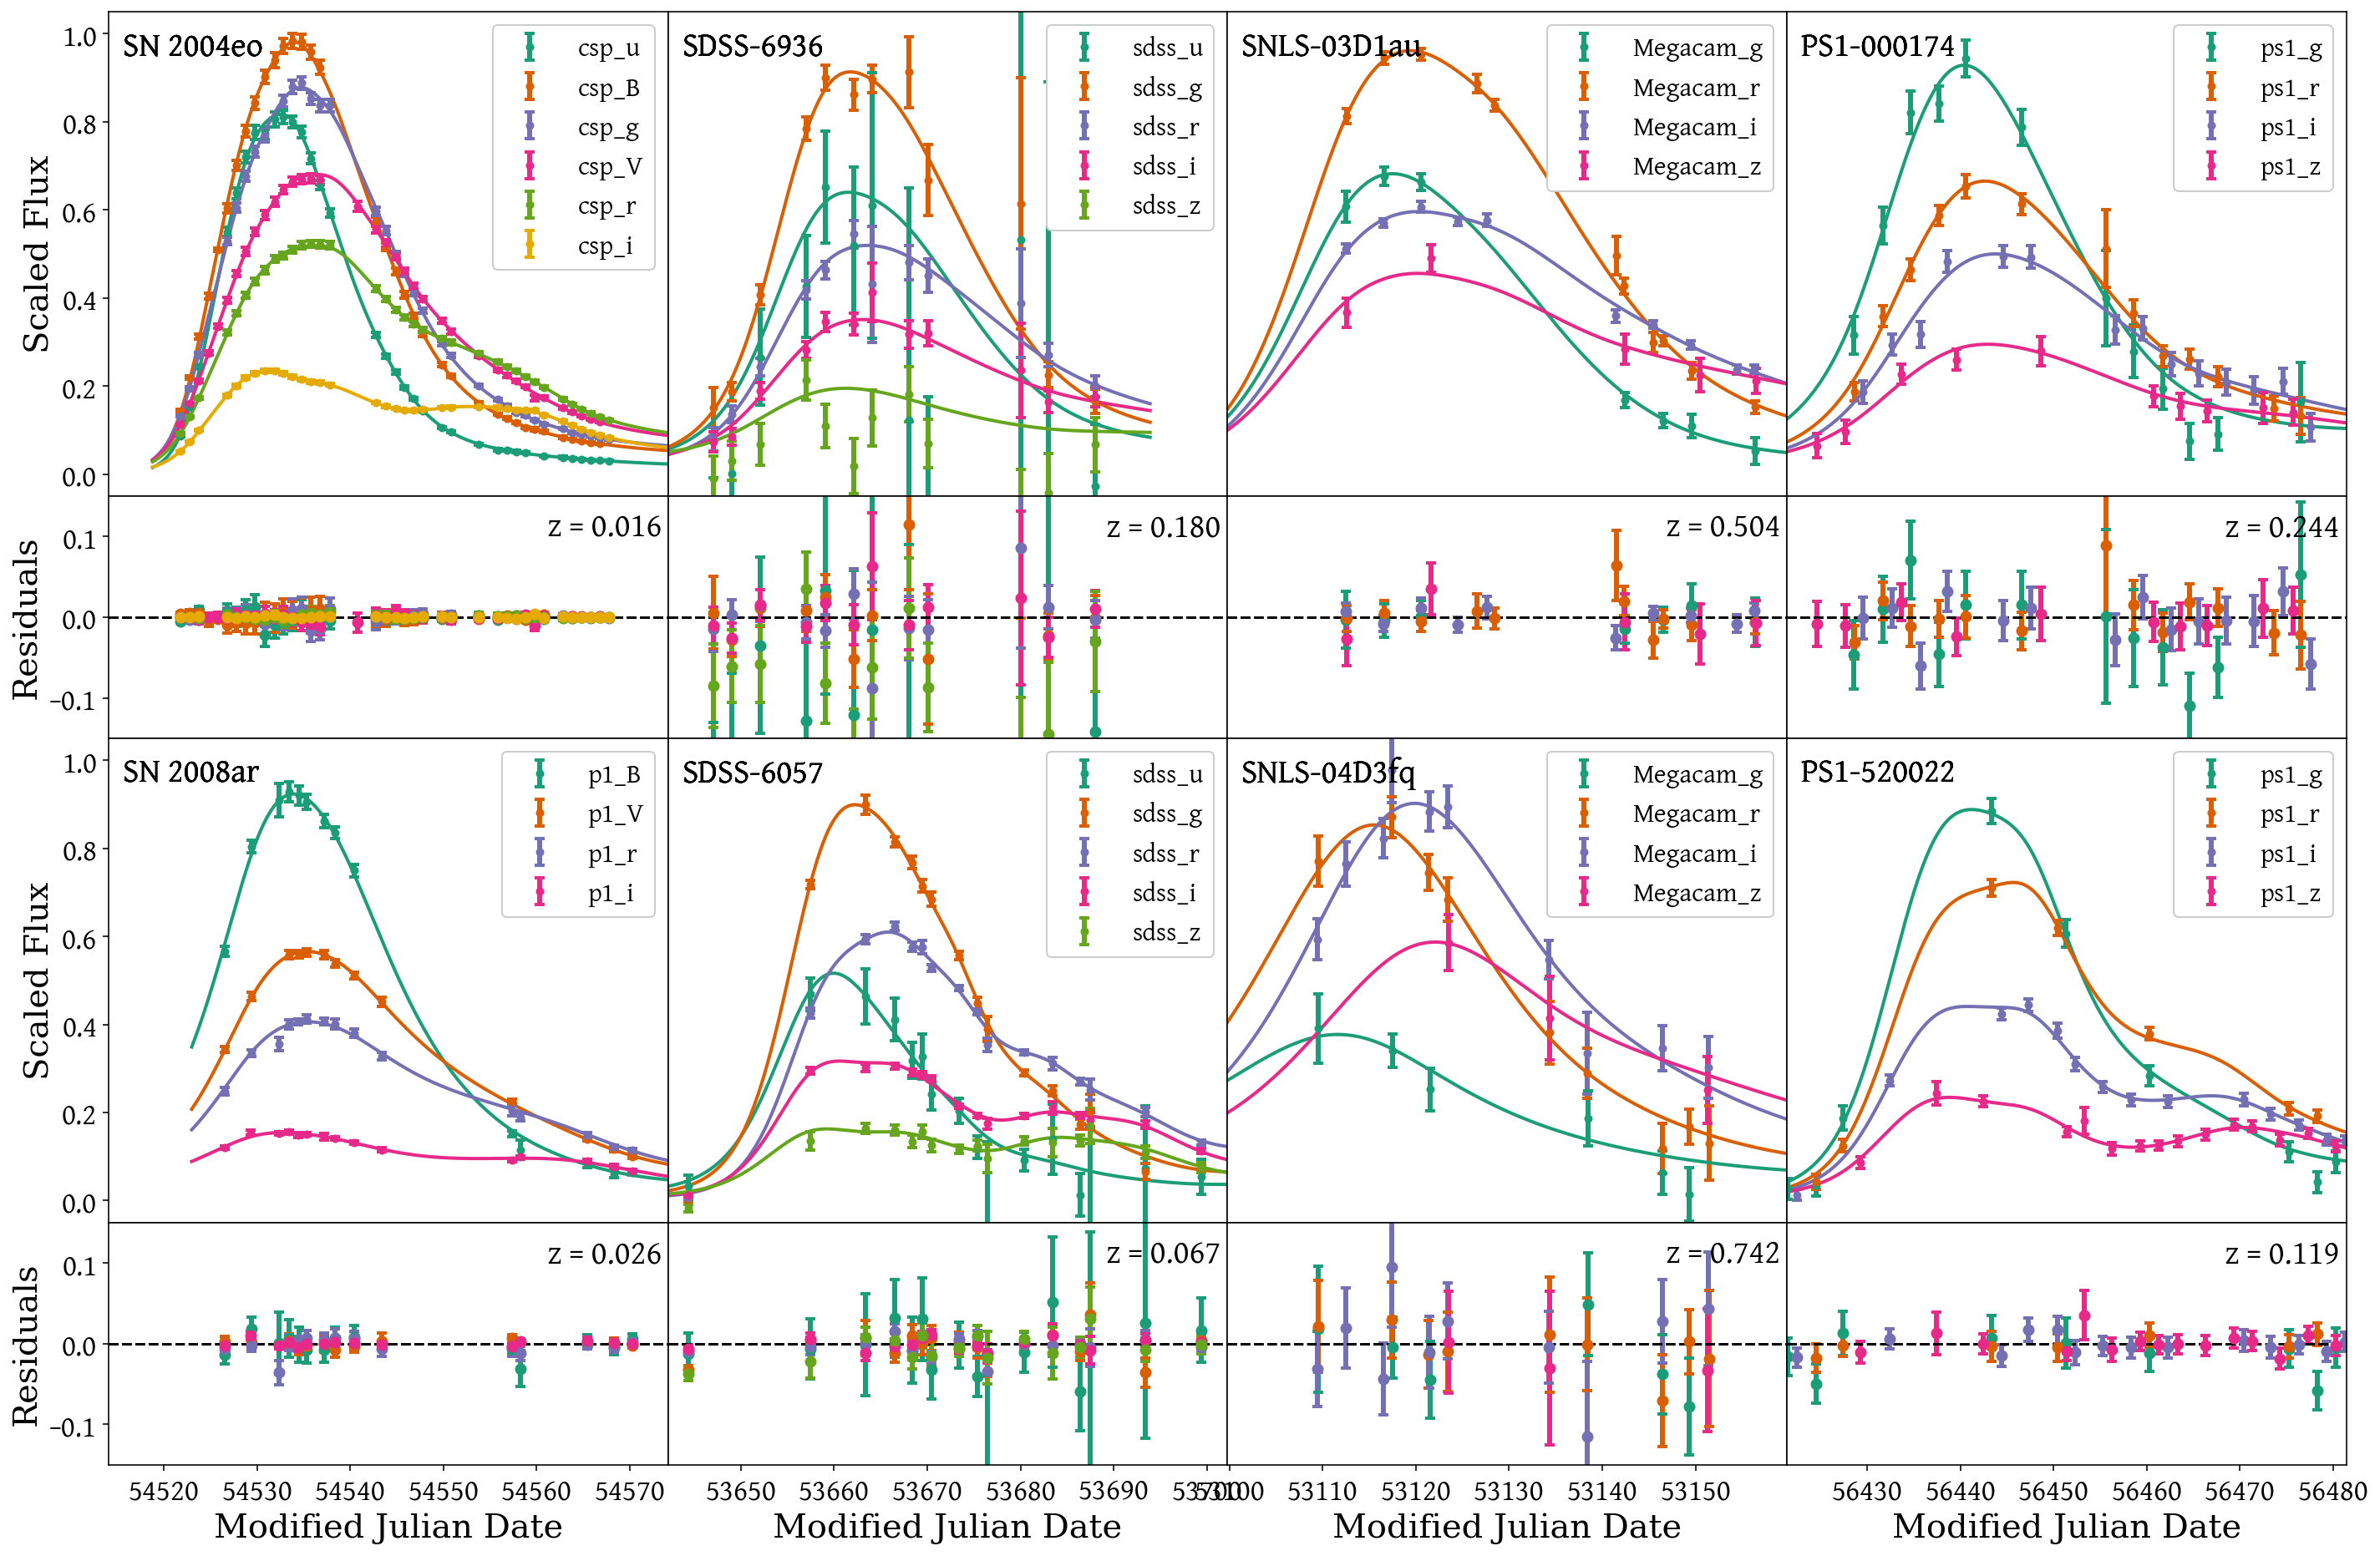

In [109]:
# plots
fig, ax = plt.subplots(4, len(sn_list), figsize=(24, 16), gridspec_kw={'height_ratios': [2, 1, 2, 1]})

for i, (name, name_salt2, y_norm, title, name_2, name_salt2_2, y_norm_2, title_2) in enumerate(zip(sn_list, sn_list_salt2, y_norms, titles, 
                                                                                              sn_list_2, sn_list_salt2_2, y_norms_2, titles_2)):
    
    # top
    sn = pisco.load_sn(name, '../analysis/obj_pantheon')  
    create_subplot(ax[0, i], sn, y_norm, title)
    create_subplot_residuals(ax[1, i], sn, y_norm, title)
    
    # bottom
    sn = pisco.load_sn(name_2, '../analysis/obj_pantheon')  
    create_subplot(ax[2, i], sn, y_norm_2, title_2)
    create_subplot_residuals(ax[3, i], sn, y_norm_2, title_2)
    
    #ax[0, i].set_title(title, fontsize=20)
    ax[0, i].set_xticks([])
    ax[1, i].set_xticks([])
    ax[2, i].set_xticks([])
    if i!=0:
        ax[0, i].set_yticks([])
        ax[1, i].set_yticks([])
        ax[2, i].set_yticks([])
        ax[3, i].set_yticks([])
    ax[3, i].set_xlabel(f'Modified Julian Date', fontsize=20, family='serif')
    ax[3, i].tick_params(labelsize=18)    

    ax[0, i].legend(fontsize=16, ncol=1, framealpha=1)
    ax[2, i].legend(fontsize=16, ncol=1, framealpha=1)
    
ax[0, 0].set_ylabel(f'Scaled Flux', fontsize=20, family='serif')
ax[1, 0].set_ylabel(f'Residuals', fontsize=20, family='serif')
ax[2, 0].set_ylabel(f'Scaled Flux', fontsize=20, family='serif')
ax[3, 0].set_ylabel(f'Residuals', fontsize=20, family='serif')
ax[0, 0].tick_params(labelsize=18)
ax[1, 0].tick_params(labelsize=18)
ax[2, 0].tick_params(labelsize=18)

plt.subplots_adjust(wspace=0, hspace=0)
if plot_type=='mag':
    plt.gca().invert_yaxis()

plt.savefig('plots/fits_comparison_piscola.pdf', bbox_inches='tight')
plt.show()

In [221]:
def create_subplot2(ax, sn, plot_type='flux', y_norm=1):
    '''Plot a SN of a subplot.
    '''
    
    for i, band in enumerate(sn.bands):

        # GP fits
        time, flux, flux_err = np.copy(sn.lc_fits[band]['time']), np.copy(sn.lc_fits[band]['flux']), np.copy(sn.lc_fits[band]['flux_err'])
        mag, mag_err = np.copy(sn.lc_fits[band]['mag']), np.copy(sn.lc_fits[band]['mag_err'])
        # Data
        data_time, data_flux, data_flux_err = np.copy(sn.data[band]['time']), np.copy(sn.data[band]['flux']), np.copy(sn.data[band]['flux_err'])
        data_mag, data_mag_err = np.copy(sn.data[band]['mag']), np.copy(sn.data[band]['mag_err'])

        if plot_type=='flux':
            flux, flux_err = flux/y_norm, flux_err/y_norm
            data_flux, data_flux_err = data_flux/y_norm, data_flux_err/y_norm

            ax.errorbar(data_time, data_flux, data_flux_err, fmt='.', capsize=3, capthick=2, ms=8,
                            elinewidth=3, color=new_palette[i])
            ax.plot(time, flux,'-', color=new_palette[i], lw=2, zorder=16, label=band)
            ax.fill_between(time, flux-flux_err, flux+flux_err, alpha=0.5, color=new_palette[i])

        elif plot_type=='mag':
            ax.errorbar(data_time, data_mag, data_mag_err, fmt='o', mec='k', capsize=3, capthick=2, ms=8,
                        elinewidth=3, color=new_palette[i],label=band)
            ax.plot(time, mag,'-', color=new_palette[i], lw=2, zorder=16)
            ax.fill_between(time, mag-mag_err, mag+mag_err, alpha=0.5, color=new_palette[i])
            #ax.set_ylabel(r'Apparent Magnitude', fontsize=16, family='serif')
            
    #ax.set_ylim(-0.05, 1.05)
    ax.set_xlim(sn.tmax-30, sn.tmax+70)

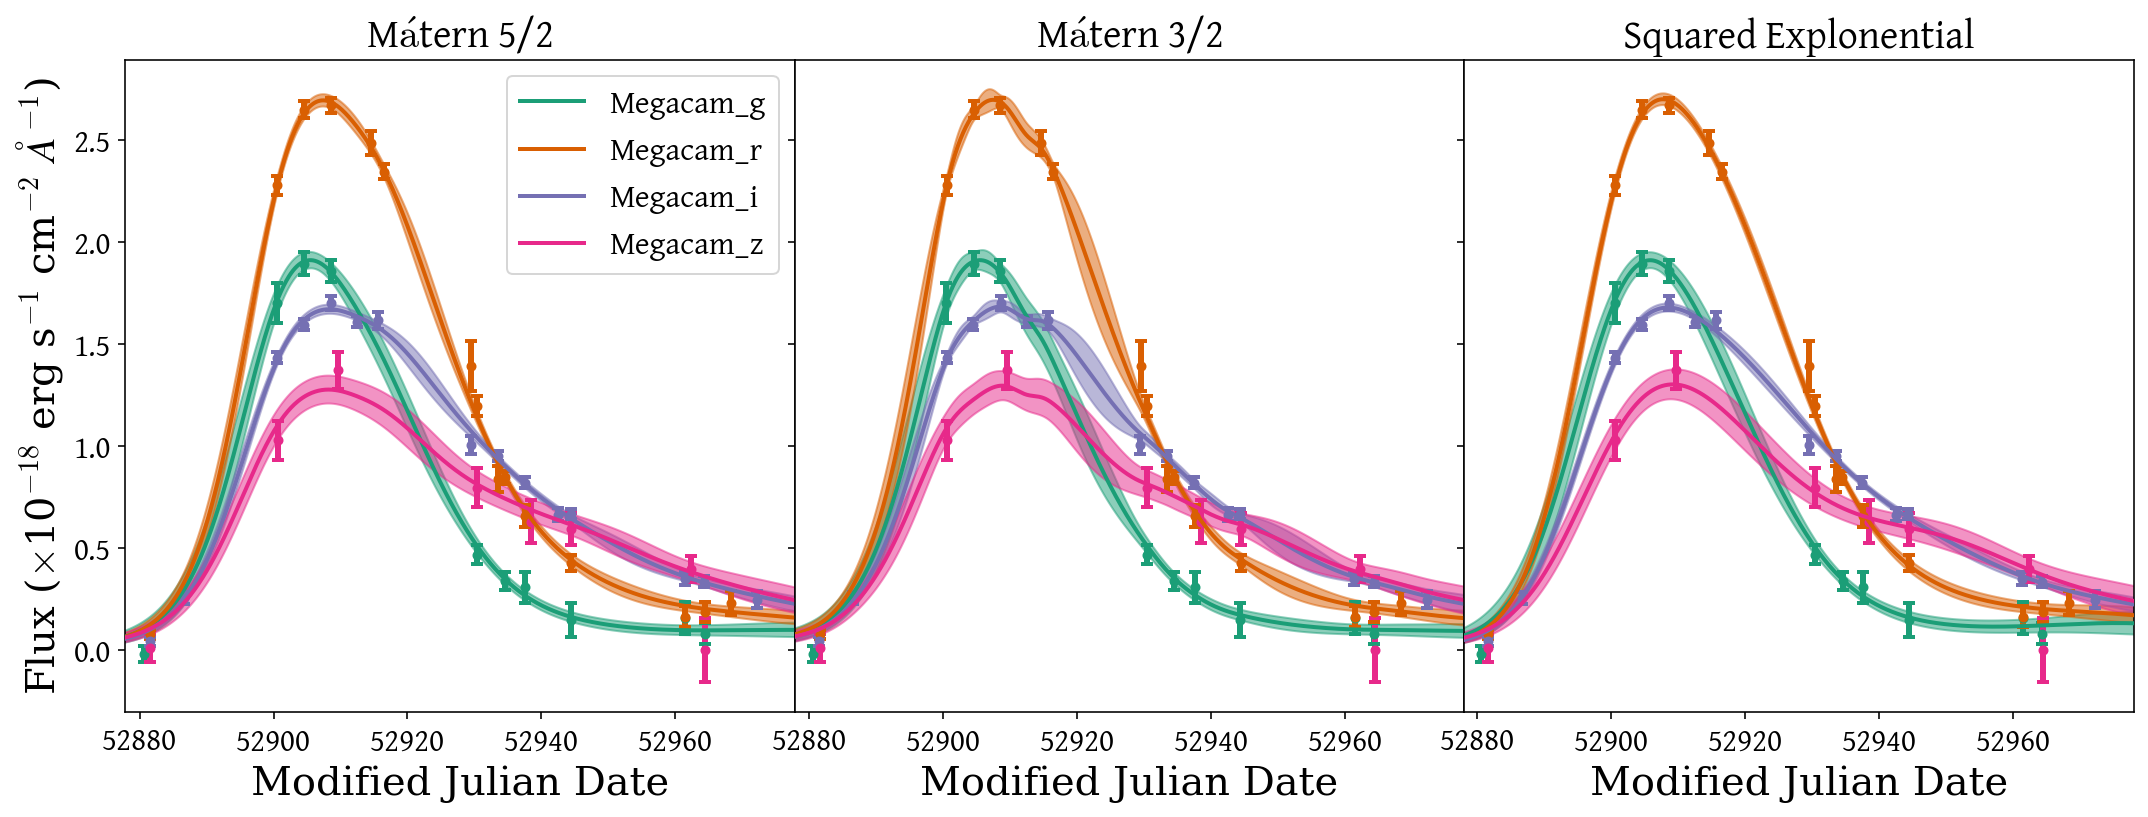

In [235]:
plot_type='flux'

name = '03D1au'
sn_list = [name, name+'_m32', name+'_se']
titles = [r'M$\'{\rm a}$tern 5/2', r'M$\'{\rm a}$tern 3/2', 'Squared Explonential']

y_norms = [1e-18]*3

# plots
fig, ax = plt.subplots(1, len(sn_list), figsize=(18, 6), sharey=True)

for i, (name, y_norm, title) in enumerate(zip(sn_list, y_norms, titles)):
    
    # piscola
    sn = pisco.load_sn(name, '../analysis/obj_pantheon')  
    create_subplot2(ax[i], sn, plot_type, y_norm)
    
    ax[i].set_title(title, fontsize=20)
    ax[i].set_xlabel(f'Modified Julian Date', fontsize=20, family='serif')
    ax[i].tick_params(labelsize=16)

ax[0].set_ylabel(r'Flux ($\times$10$^{-18}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)', fontsize=20, family='serif')
ax[0].tick_params(labelsize=16)
ax[0].legend(fontsize=16)

plt.subplots_adjust(wspace=0, hspace=0)
if plot_type=='mag':
    plt.gca().invert_yaxis()

plt.savefig('plots/kernel_fits_comparison.pdf', bbox_inches='tight')
plt.show()

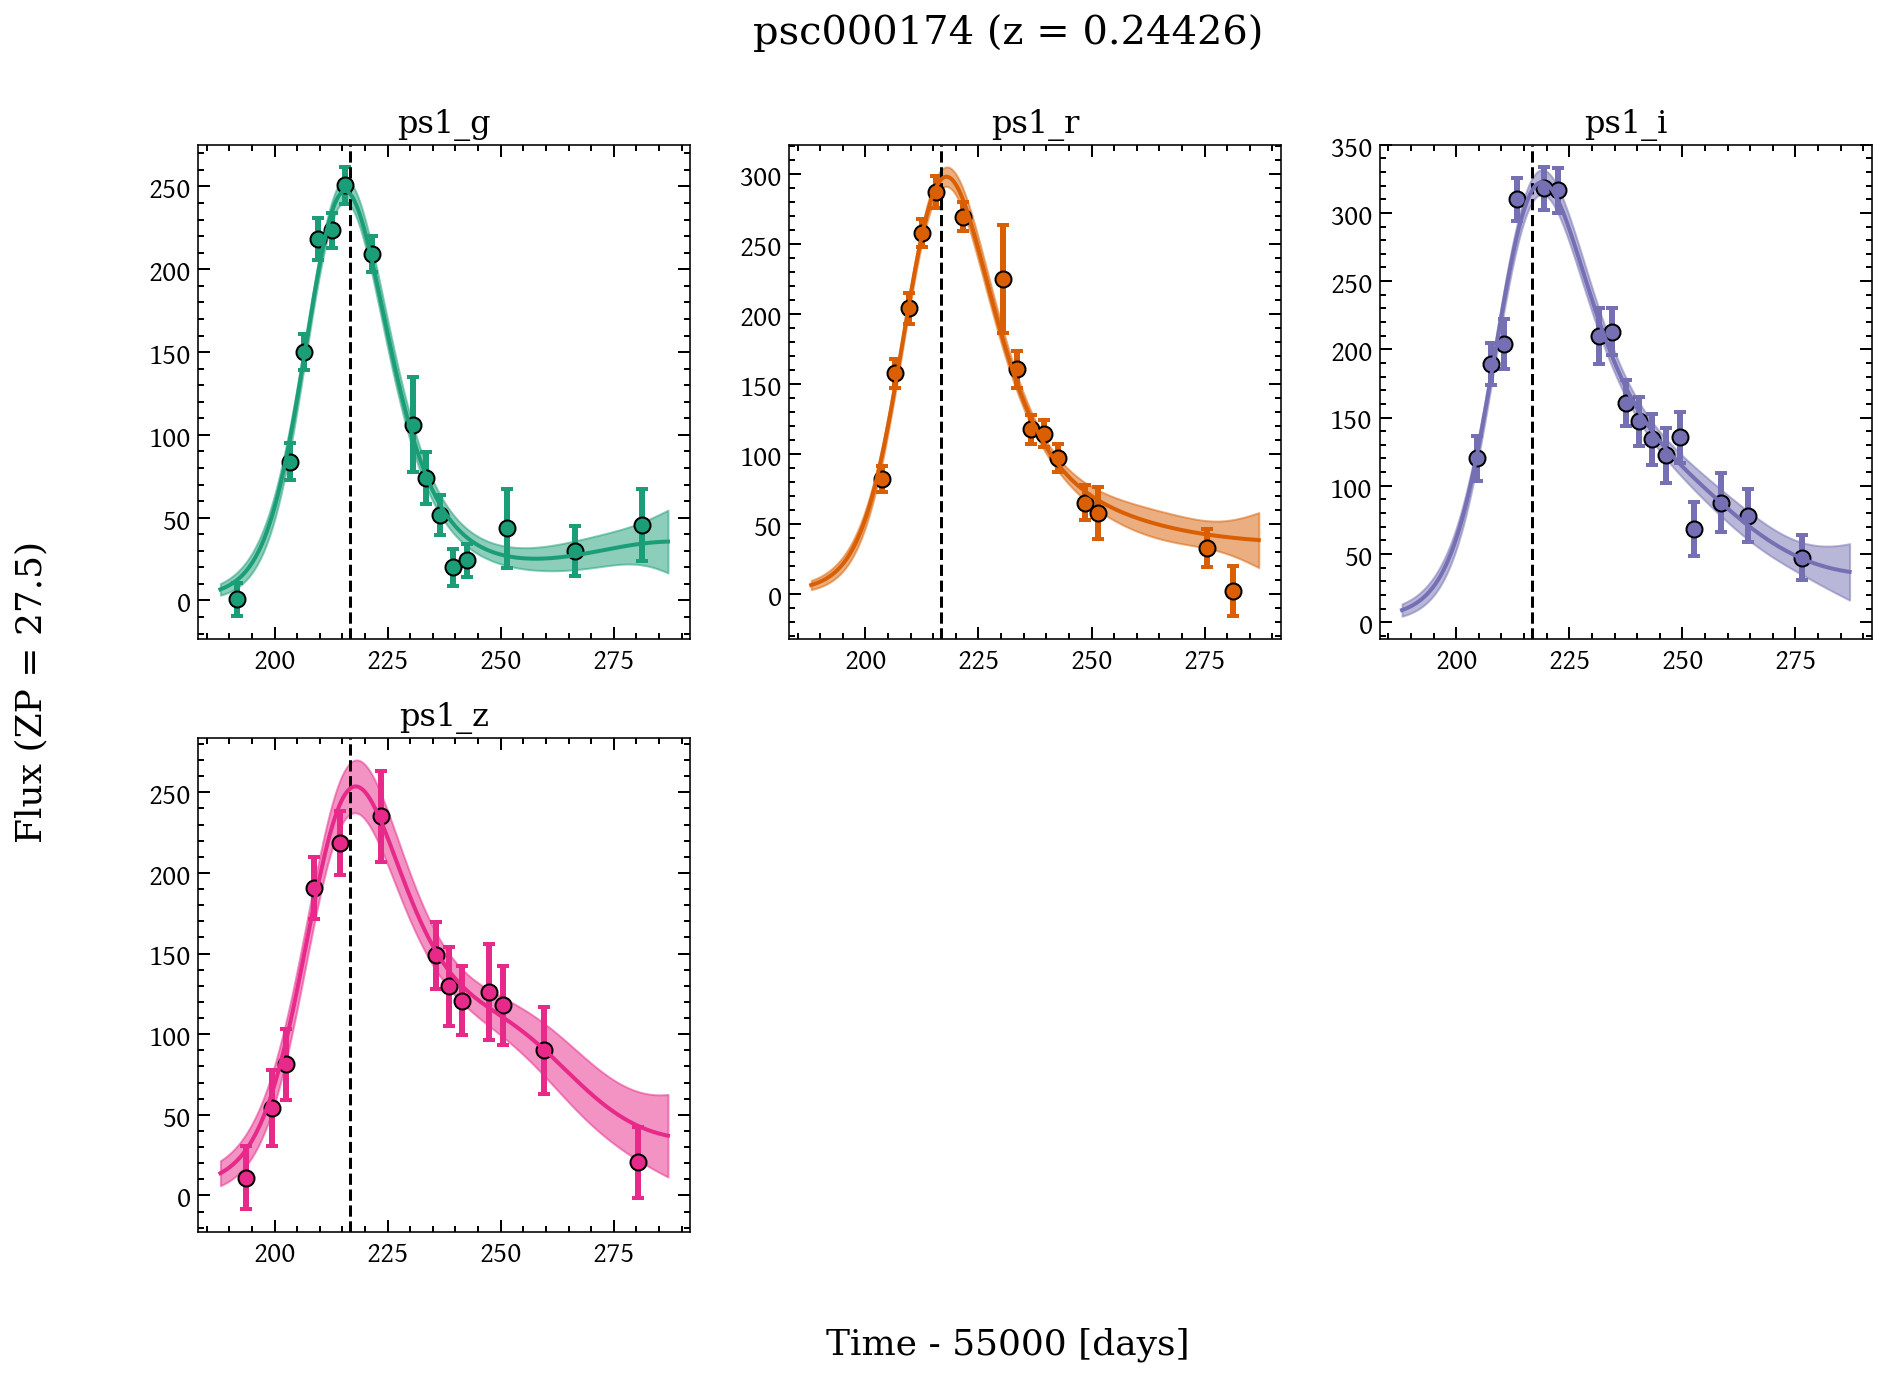

In [226]:
name = 'psc000174'
#sn = pisco.load_sn(name, '../analysis/obj_pantheon')   

sn = pisco.call_sn(name, '../analysis/data_pantheon')   
sn.normalize_data()
sn.fit_lcs('squaredexp', 'squaredexp')
sn.plot_fits()
sn.save_sn(name+'_se', '../analysis/obj_pantheon')

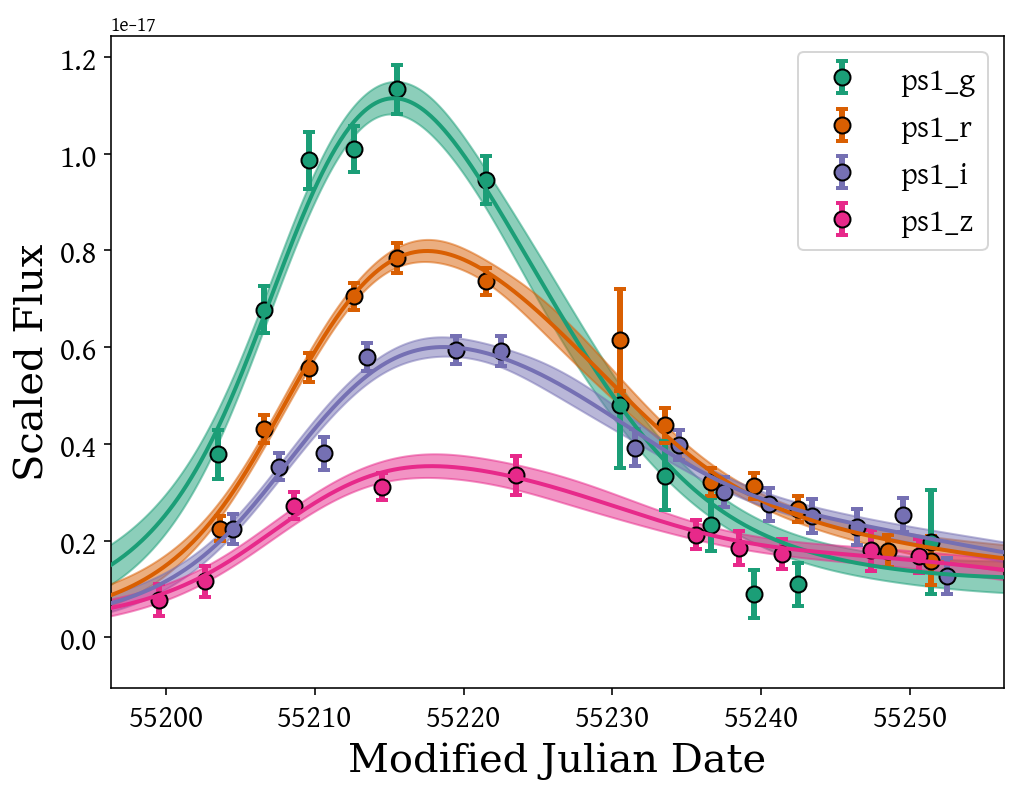

In [200]:
plot_type='flux'


fig, ax = plt.subplots(figsize=(8, 6))

sn = pisco.load_sn(name, '../analysis/obj_pantheon')  
create_plot(ax, sn, plot_type)

    
#ax.set_title(title, fontsize=20)
ax.set_xlabel(f'Modified Julian Date', fontsize=20, family='serif')
ax.tick_params(labelsize=16)

ax.set_ylabel(f'Scaled Flux', fontsize=20, family='serif')
ax.tick_params(labelsize=16)

plt.subplots_adjust(wspace=0, hspace=0)
if plot_type=='mag':
    plt.gca().invert_yaxis()

plt.savefig('plots/fites_comparison.pdf', bbox_inches='tight')
plt.show()

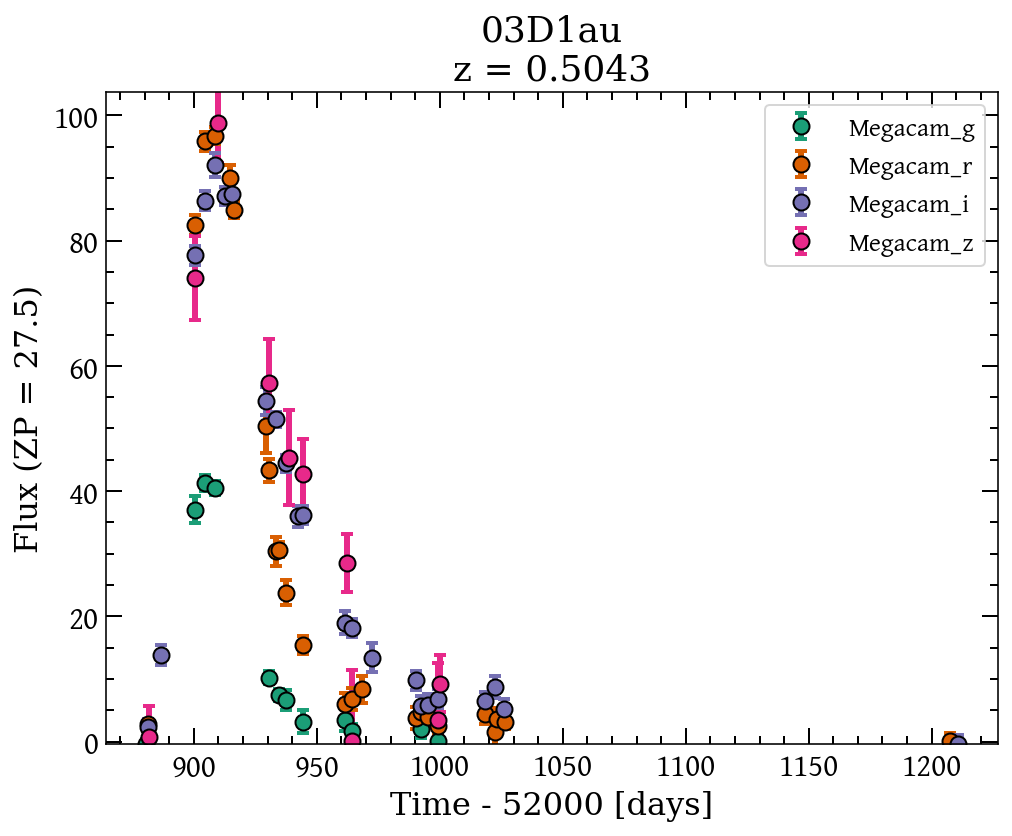

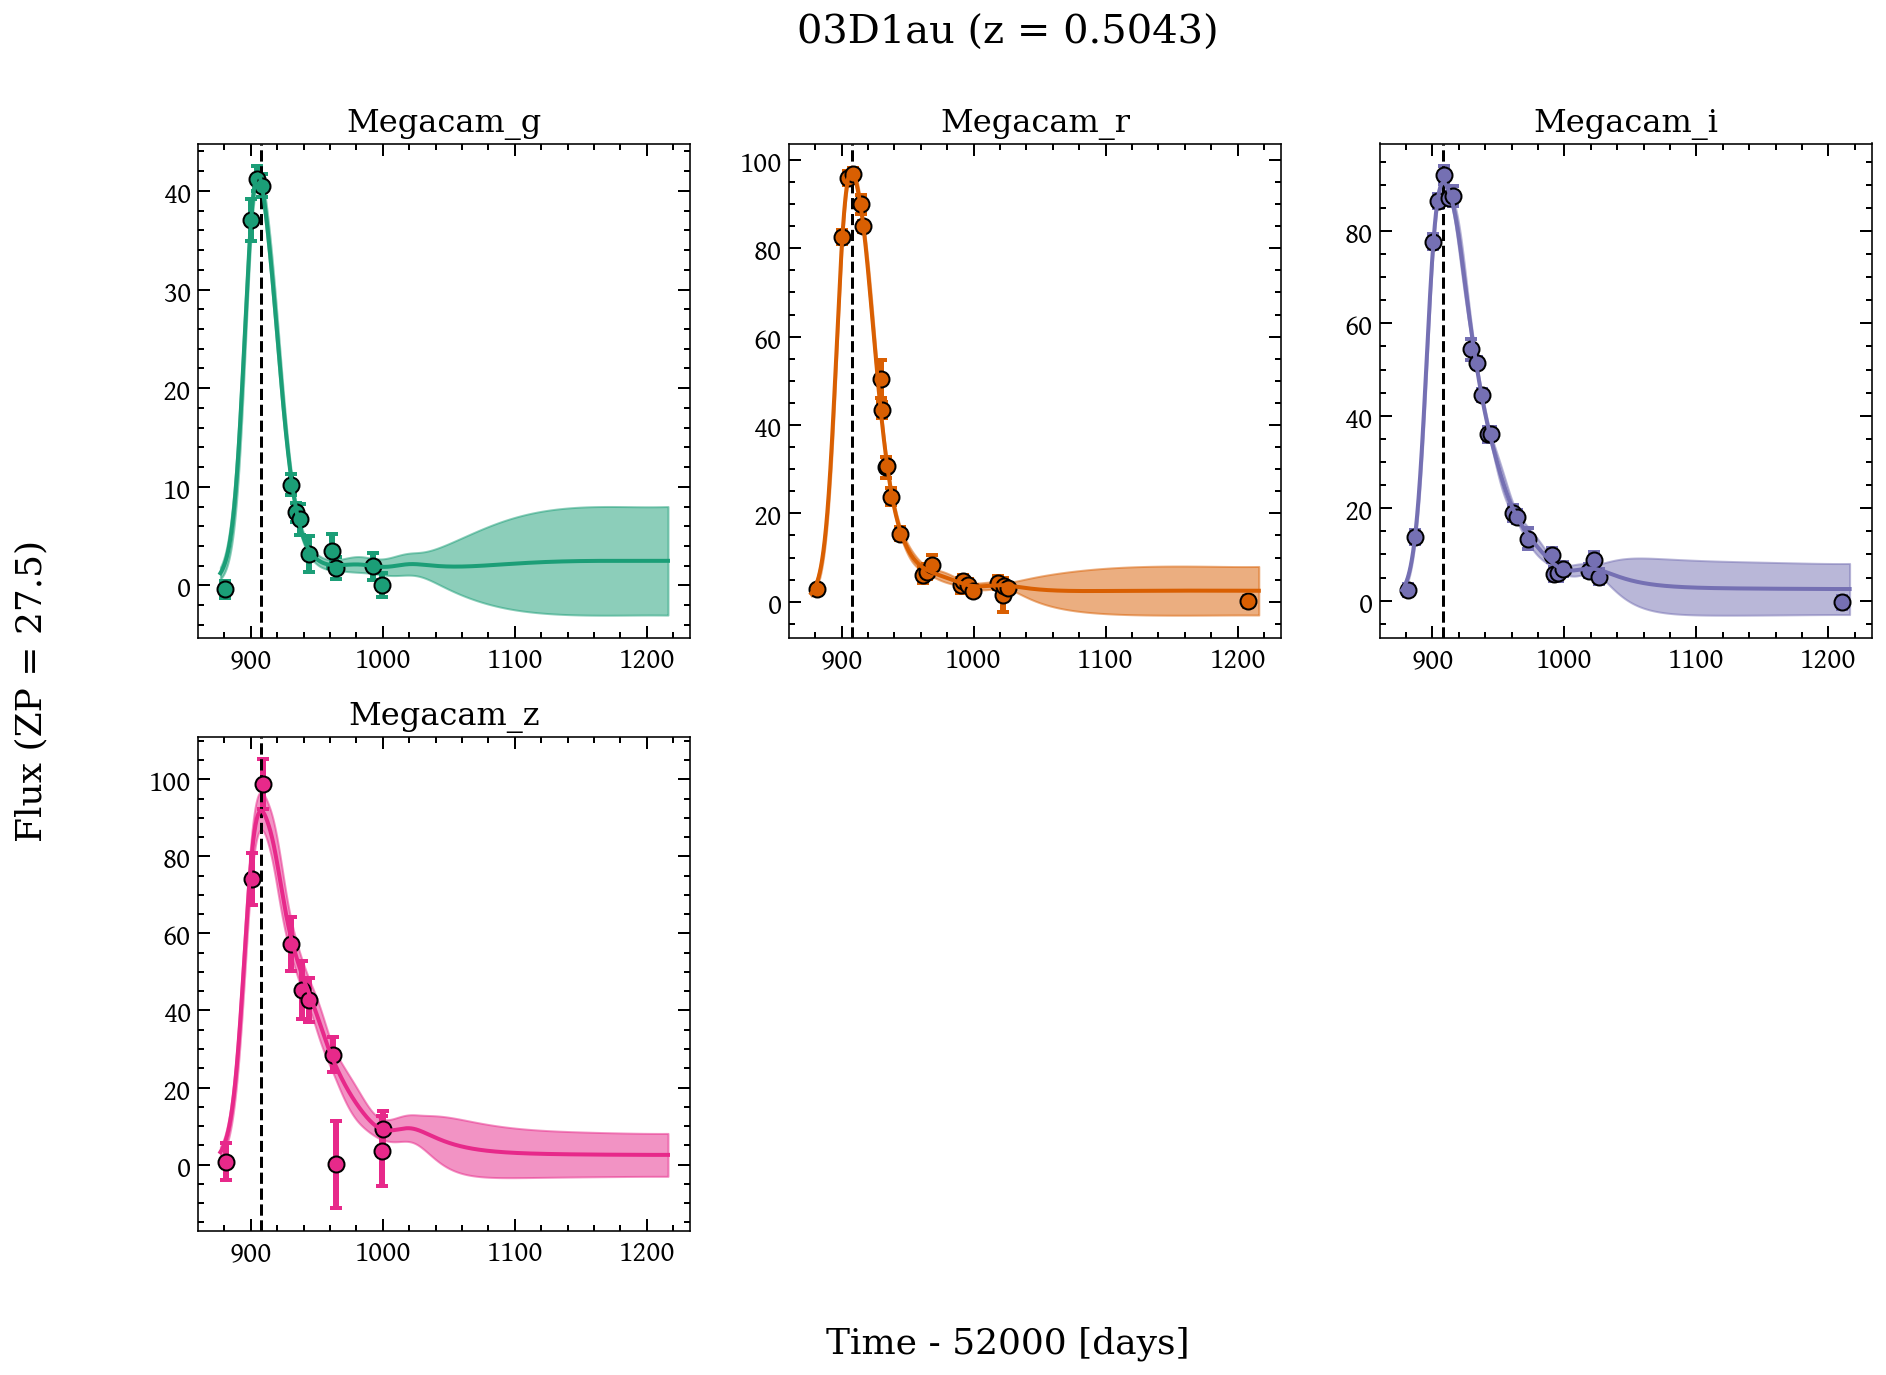

In [4]:
sn = pisco.call_sn('03D1au', directory='../analysis/data_pantheon')
sn.plot_data()
sn.fit_lcs()
sn.plot_fits()

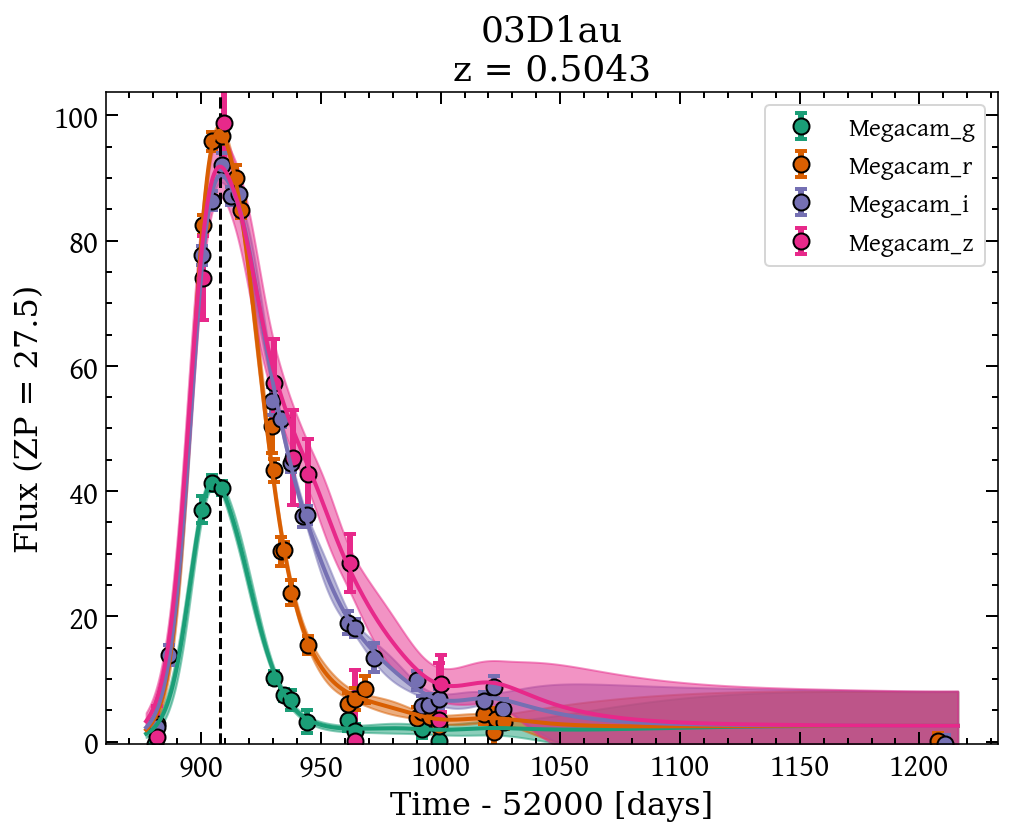

In [5]:
sn.plot_fits(True)